In [16]:
import matplotlib.pyplot as plt
from astropy.io import fits
import numpy as np
import pandas as pd

import Functions.photometry_functions as photo
import Functions.general_functions as gen

In [6]:
def find_star_pixel(img,thresh):
    """Finds the coordinates of the pixels of each star by using breadth first search to 
    recognize and collect clumps of pixels that exeed a given threshold. Returns these coordinates
    in a dict with the star number label as the key."""

    img_tf = img > thresh

    coord = dict()
    count = 0

    for r, row in enumerate(img_tf):
        for c, value in enumerate(row):
            if value == True:
                coord[str(count)] = {'x':[c],'y':[r]}
                queue=[(c,r)]
                visited=[(c,r)]
                while queue:
                    x,y = queue.pop(0)
                    img_tf[y][x] = False
                    
                    up = (x,y-1)
                    ur = (x+1,y-1)
                    rt = (x+1,y)
                    rd = (x+1,y+1)
                    dn = (x,y+1)
                    dl = (x-1,y+1)
                    lf = (x-1,y)
                    lu = (x-1,y-1)
                    
                    for loc in [up,ur,rt,rd,dn,dl,lf,lu]:
                        if loc not in visited:
                            try:
                                if img_tf[loc[1]][loc[0]] == True:
                                    coord[str(count)]['x'].append(loc[0])
                                    coord[str(count)]['y'].append(loc[1])
                                    visited.append(loc)
                                    queue.append(loc)
                            except:
                                pass
                count += 1
    return coord

def coord_and_radius(data,thresh=99):
    """Takes the coordinates from find_star_pixel and returns the center coordinate and radius of each star."""
    thresh = np.percentile(data,thresh)
    coord = find_star_pixel(data,thresh)
    star_loc = {'x':[],'y':[],'r':[]}
    for key in coord.keys():
        if len(coord[key]['x']) > 5:
            x = coord[key]['x']
            y = coord[key]['y']
            rad_x = np.max(x) - np.min(x)
            rad_y = np.max(y) - np.min(y)
            star_loc['x'].append(np.mean(x))
            star_loc['y'].append(np.mean(y))
            star_loc['r'].append((rad_x+rad_y)/2)
    return star_loc


In [7]:
M67_all_files = dict()

star_path = "Data/Clean/Sci/M67/"
for band in os.listdir(star_path):
    M67_all_files[band] = {}
    for file in os.listdir(star_path+band):
        data = fits.getdata(star_path+band+'/'+file)
        star_coord = coord_and_radius(data)
        M67_all_files[band][file] = {'data':data, 'coordinates':star_coord}

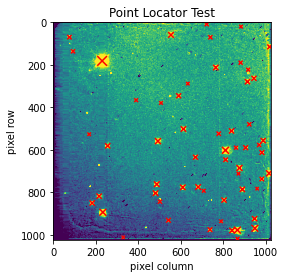

In [14]:
test = M67_all_files["B"]['Sci_2.fits']

test_coord = pd.DataFrame(test['coordinates'])
test_coord = test_coord[test_coord['r'] > 5]

plt.figure(figsize=(8.5,4))
plt.scatter(test_coord['x'],test_coord['y'],s=test_coord['r']*2,c='red',marker='x')
gen.see_image(test['data'],title='Point Locator Test');